In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X = pd.read_csv('LogReg/X.csv')
y = pd.read_csv('LogReg/y.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Preprocessing

Because our data has mixed types, let's build our own preprocessing functions to be able to handle the categorical features when we scale and encode.

In [53]:
''' 
Function to scale data without altering nominal features.
Takes 'df' (a dataframe) and 'nominal' (a list of nominal feature names).
Returns the transformed dataframe. 
'''

from sklearn.preprocessing import MinMaxScaler

def scale(df, nominal):

    scaler = MinMaxScaler()

    for var in df.columns:
            
        if var not in nominal:
            raw = df[var].to_numpy()
            raw = raw.reshape(-1, 1)

            scaler.fit(raw)
            scaled = scaler.transform(raw)
            df[var] = scaled

    return df

In [54]:
''' 
Function to one-hot encode data without altering non-nominal features.
Takes 'transform_df' (the dataframe to be encoded), 'fit_df' (the dataframe to fit the encoder to, i.e. train data), and 'nominal' (a list of nominal feature names).
Returns the transformed dataframe.
'''

from sklearn.preprocessing import OneHotEncoder

def one_hot(transform_df, fit_df, nominal):
# requires passing a list of the nominal columns 
# fit_df is the dataframe to fit the encoder onto
# transform_df is the dataframe to transform with the encoder

    # initialize encoder object
    # use 'infrequent_if_exist' for unseen categories since some features are very sparse
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', drop='first')

    # subset data
    transform_df = transform_df[nominal]
    fit_df = fit_df[nominal]

    # fit
    fit = encoder.fit(fit_df)
    
    # transform
    encoded = encoder.transform(transform_df)

    # convert result to df
    one_hot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(nominal))

    # add results to full data
    data_one_hot = pd.concat([transform_df.reset_index(drop=True), 
                              one_hot_df.reset_index(drop=True)], 
                              axis=1)

    # drop original nominal columns
    data_one_hot = data_one_hot.drop(nominal, axis=1)

    return data_one_hot

In [55]:
#since we'll use the scaled data for everything, scale X now

nominal = [
            'Marital status',      
            'Application mode',          
            'Application order',         
            'Course',                    
            'Daytime/evening attendance',
            'Previous qualification',    
            'Nationality',               
            "Mother's qualification",    
            "Father's qualification",    
            "Mother's occupation",       
            "Father's occupation",       
            'Displaced',              
            'Educational special needs', 
            'Debtor',                    
            'Tuition fees up to date',   
            'Gender',                                              
            'Scholarship holder',                                  
            'International'
            ]

X = scale(X, nominal)
X_train = scale(X_train, nominal)
X_test = scale(X_test, nominal)

# Feature Selection

The logistic regression model assumptions require us to perform feature selection before building and tuning a model, especially for the purpose of avoiding multicollinearity.<br>

The process for feature selection isn't straightforward due to the mix of nominal and interval features. <br>
This eliminates wrapper methods like recursive feature elimination because of how the nominal features must be encoded: <br>
 - One-hot/dummy encoding will cause the algorithm to misinterpret the levels of a feature as different features.  <br>
 - Label encoding will cause the algorithm to misinterpret the nominal features as ordinal. <br>
 
We can use filter methods based on statistics like mutual information, but this requires a good deal of subjective interpretation. What is the acceptable threshold? <br>
Tree-based algorithms are the most rigorous approach out of all the supervised methods due to their flexibility. We will use *boruta* and *permutation importance* and compare the results. <br>
The problem with these methods is that they won't account for multicollinearity and are prone to selecting highly correlated features. We will need to investigate this afterward.<br>

Boruta:

In [57]:
# BORUTA

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# BorutyPy expects numpy arrays
X_np = X_train.values
y_np = y_train.values
y_np = y_np.ravel()

# fit random forest classifier
rf = RandomForestClassifier(n_jobs=-1, class_weight={0:0.7, 1:0.3}, max_depth=5)
rf.fit(X_np,y_np)

# initialize and fit Boruta selector
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=1)
feat_selector.fit(X_np, y_np)

# display selected features
boruta_subset = [feature for feature, keep in zip(X_train.columns, feat_selector.support_) if keep]
boruta_subset

['Application mode',
 'Course',
 'Previous qualification (grade)',
 "Father's occupation",
 'Admission grade',
 'Debtor',
 'Tuition fees up to date',
 'Scholarship holder',
 'Age at enrollment',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)']

Permutation importance:

In [58]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

# use data that is NOT one-hot encoded
X = pd.read_csv('LogReg/X.csv')
y = pd.read_csv('LogReg/y.csv')

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# sklearn logreg expects y as a 1-d array
#y_train = y_train.values
#y_train = y_train.ravel()

#y_test = y_test.values
#y_test = y_test.ravel()

# define nominal features to pass to scale()
nominal = [
            'Marital status',      
            'Application mode',          
            'Application order',         
            'Course',                    
            'Daytime/evening attendance',
            'Previous qualification',    
            'Nationality',               
            "Mother's qualification",    
            "Father's qualification",    
            "Mother's occupation",       
            "Father's occupation",       
            'Displaced',              
            'Educational special needs', 
            'Debtor',                    
            'Tuition fees up to date',   
            'Gender',                                              
            'Scholarship holder',                                  
            'International'
            ]

# scale data
X_train = scale(X_train, nominal)
X_test = scale(X_test, nominal)

# initialize basic logreg classifier
y_train = y_train.values
y_train = y_train.ravel()
clf = LogisticRegression(solver='newton-cholesky').fit(X_train, y_train)

# initialize permutation importance
pi = permutation_importance(clf, X_train, y_train,
                           n_repeats=30,
                           random_state=1)

# display results
for i in pi.importances_mean.argsort()[::-1]:
    print(f"{X_train.columns[i]}: {pi.importances_mean[i]*1000:.3}") #multiply mean importance by 1000 for better readability


Curricular units 2nd sem (approved): 1.46e+02
Tuition fees up to date: 42.5
Curricular units 2nd sem (grade): 11.4
Course: 8.06
Age at enrollment: 6.84
Curricular units 1st sem (enrolled): 5.38
Curricular units 1st sem (approved): 4.4
Scholarship holder: 3.06
Nationality: 2.25
Curricular units 2nd sem (enrolled): 1.25
Mother's occupation: 0.571
Admission grade: 0.42
International: 0.194
Displaced: 0.118
Previous qualification: 0.0754
Educational special needs: -0.0323
Curricular units 1st sem (evaluations): -0.0538
Mother's qualification: -0.0646
GDP: -0.0646
Curricular units 2nd sem (evaluations): -0.129
Inflation rate: -0.269
Gender: -0.323
Father's occupation: -0.377
Unemployment rate: -0.528
Daytime/evening attendance: -0.689
Application mode: -0.764
Debtor: -0.818
Application order: -1.2
Marital status: -1.24
Father's qualification: -1.31
Previous qualification (grade): -1.49
Curricular units 1st sem (grade): -1.81


How do we determine an appropriate threshold for mean importance? Let's plot them and see if there is a sudden increase.

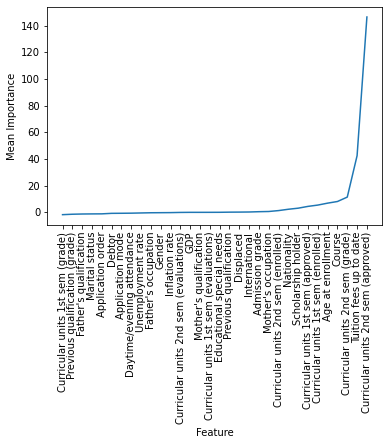

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# convert data to dataframe
pi_result = pd.DataFrame([X_train.columns, pi.importances_mean*1000, pi.importances_std*100]).T
pi_result.columns = ['Feature', 'Mean Importance', 'Std Importance']
pi_result = pi_result.sort_values(by='Mean Importance')

sns.lineplot(data=pi_result, x='Feature', y='Mean Importance')
plt.xticks(rotation=90)
plt.show() 

We see a minor sudden uptick at 'Age at enrollment', and a large uptick at 'Course'. There are a few features in the pi subset that have a small level of importance but aren't in the boruta subset. Let's test models trained from either subset and compare. If they're about even, then we'll pick features that occur in both subsets.

In [70]:
pi_subset = [
    "Curricular units 2nd sem (approved)",
    "Tuition fees up to date",
    "Curricular units 2nd sem (grade)",
    "Course",
    "Curricular units 1st sem (approved)",
    "Age at enrollment",
    "Scholarship holder",
    "Mother's occupation",
    "Mother's qualification",
    "International",
    "Gender",
    "Debtor",
    "Curricular units 2nd sem (enrolled)",
    "Nationality"
]

In [73]:
# BORUTA TEST

from sklearn.linear_model import LogisticRegressionCV

X_train_boruta = X_train[boruta_subset]
X_test_boruta = X_test[boruta_subset]

# one-hot encode data
nominal = ['Application mode', 'Course', "Mother's occupation", "Father's occupation", 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder']
X_train_boruta_oh = one_hot(X_train_boruta, X_train_boruta, nominal)
X_test_boruta_oh = one_hot(X_test_boruta, X_train_boruta, nominal)

# fit logistic regression to get accuracy score
clf = LogisticRegressionCV(random_state=1, class_weight={0:0.7, 1:0.3}, solver='newton-cholesky').fit(X_train_boruta_oh, y_train.ravel())
score = clf.score(X_test_boruta_oh, y_test.ravel())
print(f'Boruta accuracy: {score}')

c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Boruta accuracy: 0.875


In [76]:
# PERMUTATION IMPORTANCE TEST

from sklearn.linear_model import LogisticRegressionCV

X_train_pi = X_train[pi_subset]
X_test_pi = X_test[pi_subset]

# one hot encode data
nominal = [
    "Tuition fees up to date",
    "Course",
    "Scholarship holder",
    "Mother's occupation",
    "Mother's qualification",
    "International",
    "Gender",
    "Debtor",
    "Nationality"
]

X_train_pi_oh = one_hot(X_train_pi, X_train_pi, nominal)
X_test_pi_oh = one_hot(X_test_pi, X_train_pi, nominal)

# test the mi feature subset by finding the accuracy score
clf = LogisticRegressionCV(random_state=1, solver='newton-cholesky').fit(X_train_pi_oh, y_train.ravel())
score = clf.score(X_test_pi_oh, y_test.ravel())
print(f'Permuation importance accuracy: {score}')

c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3, 4, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Permuation importance accuracy: 0.8697289156626506


In [ ]:
# check for multicolinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor 

X_boruta = X_train[boruta_subset]

vif_boruta = pd.DataFrame() 

vif_boruta['Feature'] = X_boruta.columns 
  
# calculating VIF for each feature 
vif_boruta['VIF'] = [variance_inflation_factor(X_boruta.values, i) 
                          for i in range(len(X_boruta.columns))] 

vif_boruta

In [79]:
sum(vif_boruta['VIF'])

496.9751045909627

The feature set has a lot of multicolinearity. Let's prune out the features with the highest VIF scores and see if that affects accuracy. 

In [ ]:
# PRUNE MULTICOLINEAR FEATURES

def get_vif(df, subset):
# recalculates vif scores after dropping a feature

    X = X_train[subset]
    
    df['VIF'] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
    
    return df

def drop_max(df):
# iteratively drops the feature with highest vif score

    while max(df['VIF'] > 30):

        # drop feature with the highest vif
        label = df.index[df['VIF'] == max(df['VIF'])]
        df = df.drop(label, axis=0)

        # recalculate VIF scores
        subset = df['Feature'].to_list()
        df = get_vif(df, subset)

    return df

# get new dataframes with the pruned feature subsets
# use copies of the dataframes with the original subsets so they aren't altered
new_boruta = drop_max(vif_boruta.copy())
new_boruta = new_boruta.reset_index(drop=True)

new_boruta

In [ ]:
# TEST NEW FEATURE SUBSETS

from sklearn.linear_model import LogisticRegressionCV

# boruta data
X_train_boruta = X_train[new_boruta['Feature'].to_list()]
X_test_boruta = X_test[new_boruta['Feature'].to_list()]

# one hot encode boruta data
nominal = ['Application mode', 'Course', "Mother's occupation", "Father's occupation", 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder']
X_train_boruta_oh = one_hot(X_train_boruta, X_train_boruta, nominal)
X_test_boruta_oh = one_hot(X_test_boruta, X_train_boruta, nominal)

# test boruta data
clf = LogisticRegressionCV(random_state=1, solver='newton-cholesky').fit(X_train_boruta_oh, y_train.ravel())
score = clf.score(X_test_boruta_oh, y_test.ravel())
print(f'Boruta: {score}')

Removing any of these features decreases accuracy, but keeping them will interfere with any statistical analysis of the relationships being modeled. We would like to remove the multicolinearity as much as possible without sacrificing predictive power. <br>
Let's try dimension reduction.<br> Since our data is of mixed types, we'll try two approaches. We'll apply FAMD to all the features, then we'll try just applying PCA to the numeric features.<br> The multicolinearity is high among the numeric features (and not so much among the categorical features), so PCA will probably give us components with better explanatory power.

In [38]:
X_train = X_train[boruta_subset]

In [42]:
boruta_subset

['Application mode',
 'Course',
 'Previous qualification (grade)',
 "Mother's occupation",
 "Father's occupation",
 'Admission grade',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)']

In [58]:
from prince import FAMD

# convert categorical features (which are numerically encoded) to strings so that FAMD interprets them correctly
nominal = ['Application mode', 'Course', "Mother's occupation", "Father's occupation", 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder']
X_famd = X_train.copy(deep=True)
for col in nominal:
    X_famd = X_famd[col].astype('str')

famd = FAMD(
    n_components=5,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=1,
    engine="sklearn",
    handle_unknown="error"  
)
famd = famd.fit(X_train)

famd.eigenvalues_summary

KeyError: 'Course'

FAMD doesn't give a very useful result. Let's try PCA.

In [59]:
from prince import PCA

numeric = ['Admission grade',
           'Age at enrollment',
           'Curricular units 1st sem (enrolled)',
           'Curricular units 1st sem (evaluations)',
           'Curricular units 1st sem (approved)',
           'Curricular units 1st sem (grade)',
           'Curricular units 2nd sem (enrolled)',
           'Curricular units 2nd sem (evaluations)',
           'Curricular units 2nd sem (approved)',
           'Curricular units 2nd sem (grade)']

pca = PCA(
    n_components=6,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=1
)
pca = pca.fit(X_train[numeric])

pca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,5.283,52.83%,52.83%
1,1.551,15.51%,68.34%
2,1.001,10.01%,78.34%
3,0.763,7.63%,85.98%
4,0.716,7.16%,93.13%
5,0.221,2.21%,95.35%


This is much better. Let's investigate further.

In [46]:
pca.column_contributions_.style.format('{:.0%}')

component,0,1,2,3,4,5
variable,,,,,,
Admission grade,0%,7%,81%,0%,12%,0%
Age at enrollment,0%,28%,15%,17%,40%,0%
Curricular units 1st sem (enrolled),14%,9%,1%,13%,0%,0%
Curricular units 1st sem (evaluations),10%,10%,1%,9%,15%,45%
Curricular units 1st sem (approved),16%,1%,1%,4%,3%,2%
Curricular units 1st sem (grade),11%,13%,1%,13%,2%,2%
Curricular units 2nd sem (enrolled),13%,6%,0%,15%,0%,6%
Curricular units 2nd sem (evaluations),11%,5%,1%,16%,17%,41%
Curricular units 2nd sem (approved),15%,4%,0%,5%,6%,0%


In [50]:
pca.plot(
    X_train[numeric],
    x_component=0,
    y_component=1,
)

alt.LayerChart(...)

It's clear that the numeric features, especially for curricular units, overlap highly and provide very redundant information. It won't be possible to examine dependent relationships between the features and target from a model fit with these principle components, which is the problem we were trying to avoid. Let's try just getting rid of the redundant features. <br>
Permutation importance tells us that 'Curricular units 2nd sem (approved)' is the most important feature (and by a large margin too). Let's test the predictive accuracy of a model trained on a feature space where this is the only feature measuring curricular units.

In [80]:
test_subset = ['Application mode',
               'Course',
               "Mother's occupation",
               "Father's occupation",
               'Debtor',
               'Tuition fees up to date',
               'Gender',
               'Scholarship holder',
               'Admission grade',
               'Previous qualification (grade)',
               'Age at enrollment',
               'Curricular units 2nd sem (approved)']

clf = LogisticRegressionCV(random_state=1, solver='newton-cholesky').fit(X_train[test_subset], y_train.ravel())
score = clf.score(X_test[test_subset], y_test.ravel())
print(f'Accuracy: {score}')

Accuracy: 0.8621987951807228


There's only a small decrease in accuracy. We'll keep all the features for the purpose of our predictive model, but use only this 'test_subset' when we do inferential analysis.

In [33]:
# create and save the final, preprocessed dataset that will be used 

final_subset = boruta_subset
final_subset.append('Target')
final_subset

nominal=['Application mode','Course',"Mother's occupation","Father's occupation",'Debtor','Tuition fees up to date','Gender','Scholarship holder']

all_data = pd.read_csv('data_clean.csv')
data_subset =  all_data[final_subset]

X = data_subset.drop('Target', axis=1)
y = data_subset['Target']

X = scale(X, nominal)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

X_train_oh = one_hot(X_train, X_train, nominal)
X_test_oh = one_hot(X_test, X_train, nominal)

c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [34]:
X_train_oh.to_csv('LogReg/X_train.csv', index=False)
X_test_oh.to_csv('LogReg/X_test.csv', index=False)
y_train.to_csv('LogReg/y_train.csv', index=False)
y_test.to_csv('LogReg/y_test.csv', index=False)

# Model Tuning

In [3]:
#load data

X_train = pd.read_csv('LogReg/X_train.csv')
X_test = pd.read_csv('LogReg/X_test.csv')

y_train = pd.read_csv('LogReg/y_train.csv')
y_test = pd.read_csv('LogReg/y_test.csv')

y_train = y_train.values
y_test = y_test.values

y_train = y_train.ravel()
y_test = y_test.ravel()


### Vanilla

Let's inspect the perfomance of the vanilla model to compare for later.

In [9]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, make_scorer, ConfusionMatrixDisplay, RocCurveDisplay

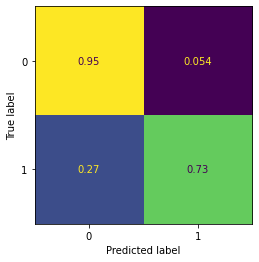

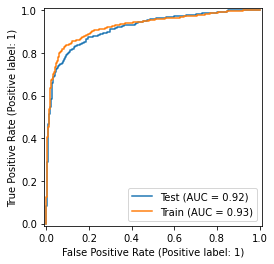

Mean accuracy: 0.8817771084337349


In [37]:
# CONFUSION MATRIX
import matplotlib.pyplot as plt

clf_vanilla = LogisticRegressionCV().fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(clf_vanilla, X_test, y_test, normalize='true', colorbar=False)

# ROC
fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf_vanilla, X_test, y_test, ax=ax, name='Test')
train_auc = RocCurveDisplay.from_estimator(clf_vanilla, X_train, y_train, ax=ax, name='Train')

plt.show()

y_pred = clf_vanilla.predict(X_test)
print(f'Mean accuracy: {accuracy_score(y_pred, y_test)}')

The mean accuracy is 0.88<br>
0.54% of true negative cases are falsely predicted. 27% of true positive cases are falsely predicted. That's a huge rate of false negatives. We'd rather have some bias toward false positives, if any. <br>
The ROC curves are very similar, indicating an appropriate amount of fitting. 

### Hyperparameters

Use grid search to evaluate the different possible parameter combinations.

In [38]:
from sklearn.model_selection import GridSearchCV

# define possible parameters
parameters = {'penalty':['l1', 'l2'], # exclude penalties 'none' and 'elasticnet' because they produce NaN
              'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'saga'], # exclude sag because it never converges
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]} # use logarithmic scale to test wide range of C values 

# fit 
lrg = LogisticRegression(max_iter=500)
f1 = make_scorer(f1_score)
clf = GridSearchCV(lrg, parameters, scoring=['accuracy', 'recall', 'f1'], return_train_score=True, refit=False)

clf.fit(X_train, y_train)

# store results
gs_results = pd.DataFrame(clf.cv_results_)

c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: T

Filter the results dataframe and reformat into a digestible form.

In [39]:
# remove rows with NaN
# these rows represent incompatible parameter combinations
gs_results = gs_results.dropna(axis=0)

# columns of interest
columns = ['param_C', 'param_penalty', 'param_solver', 
           'mean_test_accuracy', 
           'mean_test_recall', 
           'mean_test_f1']


In [40]:
# VIEW HIGHEST RECALL
gs_recall = gs_results[columns].sort_values(by='mean_test_recall', axis=0, ascending=False, ignore_index=True)
gs_recall.head()

,param_C,param_penalty,param_solver,mean_test_accuracy,mean_test_recall,mean_test_f1
0,1000.0,l2,saga,0.868867,0.728881,0.785275
1,1000.0,l2,newton-cg,0.868543,0.728881,0.784851
2,1000.0,l1,saga,0.868867,0.728881,0.785275
3,1000.0,l2,lbfgs,0.868543,0.728876,0.784836
4,1000.0,l1,liblinear,0.867575,0.727900,0.783387


In [41]:
# VIEW HIGHEST ACCURACY
gs_accuracy = gs_results[columns].sort_values(by='mean_test_accuracy', axis=0, ascending=False, ignore_index=True)
gs_accuracy.head()

,param_C,param_penalty,param_solver,mean_test_accuracy,mean_test_recall,mean_test_f1
0,1.0,l1,saga,0.874035,0.723974,0.790799
1,1.0,l1,liblinear,0.873712,0.724954,0.790667
2,10.0,l2,lbfgs,0.872742,0.726915,0.789780
3,10.0,l2,saga,0.872096,0.724944,0.788517
4,10.0,l2,newton-cg,0.872096,0.724944,0.788517


In [42]:
# VIEW LOWEST ACCURACY
low_acc = gs_results[columns].sort_values(by='mean_test_accuracy', axis=0, ascending=True, ignore_index=True)
low_acc.head()

,param_C,param_penalty,param_solver,mean_test_accuracy,mean_test_recall,mean_test_f1
0,0.001,l1,liblinear,0.671189,0.0,0.0
1,0.001,l1,saga,0.671189,0.0,0.0
2,0.001,l2,lbfgs,0.671189,0.0,0.0
3,0.001,l2,newton-cg,0.671189,0.0,0.0
4,0.001,l2,newton-cholesky,0.671189,0.0,0.0


The model with the highest accuracy is no better than default parameters.<br><br>
It seems that the model isn't very sensitive to penalty or solver, but accuracy is maximized with moderate C values while recall is maximized with large C values. It does not like very small C values.<br>
While accuracy and recall are maximized by different parameters, the model with the highest accuracy has only a very slight decrease in recall. Also, parameters alone can't produce the desired ratio of recall to precision.<br>

c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


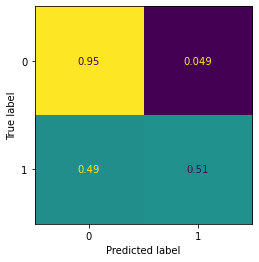

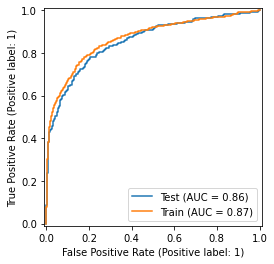

In [16]:
# CONFUSION MATRIX
import matplotlib.pyplot as plt

clf_param_tuned = LogisticRegression(C=1, penalty='l1', solver='saga', max_iter=10000).fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(clf_param_tuned, X_test, y_test, normalize='true', colorbar=False)

# ROC
fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf_param_tuned, X_test, y_test, ax=ax, name='Test')
train_auc = RocCurveDisplay.from_estimator(clf_param_tuned, X_train, y_train, ax=ax, name='Train')

plt.show()

The confusion matrix and ROC curves are identical to those of the default model. We will proceed with default hyperparameters, except solver = saga.<br>
We'll tune the decision threshold to balance the ratio of false positives and false negatives.

### Decision threshold

We'll use Youden's J Statistic to find the threshold closest to the top left corner of the ROC curve. 

Best threshold = 0.32831371745565424


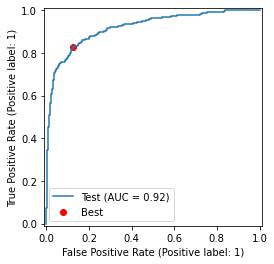

In [44]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt

# get probabilities for the positive case
yhat = clf_param_tuned.predict_proba(X_test)[:, 1]

# get roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)

# find best threshold
J = tpr - fpr
idx = np.argmax(J)
best_thresh = thresholds[idx]

print(f'Best threshold = {best_thresh}')

# plot the roc curve showing the optimal threshold
fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf_param_tuned, X_test, y_test, ax=ax, name='Test')
plt.scatter(fpr[idx], tpr[idx], marker='o', color='red', label='Best')
plt.legend()

plt.show()

Accuracy: 0.8614457831325302


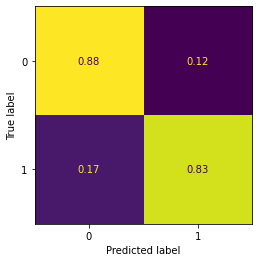

In [45]:
# get class labels using new threshold
y_prob = clf_param_tuned.predict_proba(X_test)[:, 1]
y_pred = np.where(y_prob > best_thresh, 1, 0)

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', colorbar=False)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Using the new threshold, 17% of true positives are falsely predicted and 12% of true negatives are falsely predicted. This is decently balanced, but we'd like the false positive rate to be a little higher than the false negative rate (the inverse of what is happening). Let's tweak the threshold just a bit to accomplish this. Let's test a few nearby thresholds using cross validation and see what error ratios they produce.

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# rejoin train and test sets
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y = pd.concat([y_train, y_test], axis=0, ignore_index=True)

# get cv folds
skf = StratifiedKFold()

# create lists for value storage
test_thresholds = np.arange(0.22, 0.30, 0.01)

mean_stats = [[] for _ in range(3)]

# test thresholds
for i, threshold in enumerate(test_thresholds):

    stats = [[] for _ in range(3)]

    # for each cv fold
    for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        # train model
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_train = np.ravel(y_train)
        clf_param_tuned.fit(X_train, y_train)
        y_prob = clf_param_tuned.predict_proba(X_test)[:, 1]
        y_pred = np.where(y_prob > threshold, 1, 0)

        # get errors
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        stats[0].append(accuracy_score(y_test, y_pred))
        stats[1].append(cm[0, 1])
        stats[2].append(cm[1, 0])

    # save mean errors across folds
    mean_stats[0].append(np.mean(stats[0]))
    mean_stats[1].append(np.mean(stats[1]))
    mean_stats[2].append(np.mean(stats[2]))

# show results
result = pd.DataFrame({'Threshold': test_thresholds,
                       'Accuracy': mean_stats[0],
                       'Type I Error': mean_stats[1],
                       'Type II Error': mean_stats[2]})
result

,Threshold,Accuracy,Type I Error,Type II Error
0,0.22,0.830919,0.187826,0.129508
1,0.23,0.836119,0.178169,0.133734
2,0.24,0.839736,0.170510,0.138661
3,0.25,0.844934,0.160854,0.142881
4,0.26,0.849229,0.152194,0.147806
5,0.27,0.852846,0.145532,0.150623
6,0.28,0.854428,0.141536,0.154139
7,0.29,0.857367,0.134543,0.159770


The ideal balance depends on what percent of future dropouts we are willing to have our model miss. The tradeoff between missing future dropouts and providing intervention measures to students who won't drop out is something that will need to be discussed with the school administration. The final model would have a decision threshold tuned according to the admin's perference. The bias toward false positives means that a lower threshold could increase the number of potential dropouts caught early, desite a lower overall model accuracy. For now, we will consider 0.26 to be our ideal threshold. Our decision now is unimportant since this is a very easy thing to change as needed.